In [1]:
import csv
import os
import math
from networktables import NetworkTables
import logging
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import time

In [2]:
logger = logging.getLogger('nt')
logger.setLevel(logging.DEBUG)
logging.basicConfig()

In [5]:
NetworkTables.initialize(server="127.0.0.1")

INFO:nt:NetworkTables initialized in client mode
DEBUG:nt.th:Started thread nt-dispatch-thread-0
DEBUG:nt.th:Started thread nt-client-thread-0


False

In [7]:
class DataCollector:
    def __init__(self, table, folder='.', csv_filename='data.csv', target_radius = 0.127, plate_thickness=0.01,
                 start_pan_angle=0.0, end_pan_angle=1795.0, step_pan_angle=5.0, pan_rotations=2, pan_steps_per_rotations=36, 
                 camera_h_fov=72.2, camera_h_res=3264, camera_v_res=2448, camera_id=1, flip_image=True):
        self.table = table
        self.folder = folder
        self.csv_path = os.path.join(folder, csv_filename)
        self.target_radius = target_radius
        self.plate_thickness = plate_thickness
        self.start_pan_angle = start_pan_angle
        self.end_pan_angle = end_pan_angle
        self.step_pan_angle = step_pan_angle
        self.pan_steps_per_rotations = pan_steps_per_rotations
        self.pan_rotations = pan_rotations
        self.step_pan_angle_rot = 360.0 / self.pan_steps_per_rotations
        self.camera_h_fov = camera_h_fov
        self.camera_h_res = camera_h_res
        self.camera_v_res = camera_v_res
        self.flip_image = flip_image
        # assume square pixels
        self.res_per_deg = self.camera_h_res / self.camera_h_fov
        # assume center of camera image until adjusted
        self.center_x = int(self.camera_h_res / 2)
        self.center_y = int(self.camera_v_res / 2)
        self.camera_id = camera_id
        self.state = None
        self.run_started = False
        self.run_done = False
        self.pan_started = False
        self.pan_done = False
        self.tilt_angle = None
        self.pan_angle = None
        self.ground_distance = None
        self.slope_distance = None
        
    def startRun(self, base_file_name):
        self.base_file_name = base_file_name
        # get current state, distance, and angles
        self.state = self.table.getString("State", None)
        self.tilt_angle = self.table.getNumber("TiltAngle", None)
        self.pan_angle = self.table.getNumber("PanAngle", None)
        self.ground_distance = self.table.getNumber("GroundDistance", None)
        self.slope_distance = self.table.getNumber("SlopeDistance", None)
        # we haven't started a run yet
        self.run_started = False
        self.run_done = False
        self.pan_started = False
        self.pan_done = False
        self.next_pan_angle = None
        self.sequence = 1
        self.pan_index = 0
        self.data = []
        self._openCamera()
        self.table.addEntryListener(self._changeHandler)

    def _openCamera(self):
        # open the camera
        self.cap = cv2.VideoCapture(self.camera_id, cv2.CAP_DSHOW)
        # disables auto exposure
        #self.cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 1)
        #self.cap.set(cv2.CAP_PROP_EXPOSURE, 8)
        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, self.camera_h_res)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, self.camera_v_res)
        print(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        print(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        # camera needs time to adjust so capture 10 images
        for i in range(10):
            print(i)
            ret, image = self.cap.read()
        print('camera ready')
        
    def _updateValue(self, key, value):
        if key == 'State':
            self.state = value
        elif key == 'TiltAngle':
            self.tilt_angle = value
        elif key == 'PanAngle':
            self.pan_angle = value
        elif key == 'GroundDistance':
            self.ground_distance = value
        elif key == 'SlopeDistance':
            self.slope_distance = value
            
    def _changeHandler(self, table, key, value, isNew):
        self._updateValue(key, value)
        # finite state machine
        if self.state == 'STANDBY':
            if self.run_started:
                # run is complete
                self.run_done = True
                self.cap.release()
                self.table.removeEntryListener(self._changeHandler)
                self._writeData()
                #print('Run Complete')
        elif self.state == 'PREPARE':
            self.pan_started = False
            self.pan_done = False
        elif self.state == 'ROTATE_COLLECT':
            if not self.run_started:
                self.run_started = True
            if not self.pan_started:
                self.next_pan_angle = self.start_pan_angle
                self.pan_started = True
            if not self.pan_done and self.pan_angle >= self.next_pan_angle:
                filename = self.base_file_name + "%04d" % self.sequence + '.jpg'
                row = self._saveImage(filename)
                self.data.append(row)
                self.sequence += 1
                if self.pan_angle >= self.end_pan_angle:
                    self.pan_done = True
                else:
                    self.pan_index += 1
                    if self.pan_index % self.pan_steps_per_rotations == 0:
                        self.next_pan_angle += self.step_pan_angle_rot + self.step_pan_angle
                    else:
                        self.next_pan_angle += self.step_pan_angle_rot

    # returns data row with filename, pan_angle, tilt_angle, ground_distance, and slope_distance
    def _saveImage(self, filename):
        # capture current values
        pan_angle = self.pan_angle
        tilt_angle = self.tilt_angle
        ground_distance = self.ground_distance
        slope_distance = self.slope_distance

        ret, image = self.cap.read()
        if not ret:
            raise Exception('Could not read image from camera')
        if self.flip_image:
            image = cv2.flip(image, -1)
        
        center, radii = self._calculateEllipse(tilt_angle, slope_distance)
        
        # Create a mask (e.g., a black circle on a white background)
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.ellipse(mask, center, radii, 0, 0, 360, 255, -1)
        # Apply the mask to the image
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        image_crop = masked_image[int(center[1] - radii[1]):int(center[1] + radii[1]),
                                  int(center[0] - radii[0]):int(center[0] + radii[0])]
        cv2.imwrite(os.path.join(self.folder, filename), image_crop)
        return [filename, pan_angle, tilt_angle, ground_distance, slope_distance]
                    
    def _writeData(self):
        is_new = not os.path.exists(self.csv_path)
        print(f'Updating file {self.csv_path}') 
        with open(self.csv_path, 'a', newline='') as csvfile:
            writer = csv.writer(csvfile)
            if is_new:
                headers = ['FILE_NAME', 'PAN_ANGLE', 'TILT_ANGLE', 'GROUND_DISTANCE', 'SLOPE_DISTANCE']
                writer.writerow(headers)
            writer.writerows(self.data)

    # should be done at tilt of 90 degrees
    # robot should be in MANUAL_DRIVE state
    def adjustImageCenter(self, slope_distance, target_radius=0.045, view_size=640):
        crop_size = 2 * self.res_per_deg * math.atan2(target_radius, slope_distance) * 180 / math.pi
        self._openCamera()
        # initial step size of 16 pixels
        step = 16
        while True:
            # read the next frame
            ret, image = self.cap.read()
            if not ret:
                raise Exception('Could not read image from camera')
            if self.flip_image:
                image = cv2.flip(image, -1)
        
            # crop the center
            image_crop = image[int(self.center_y - crop_size/2):int(self.center_y + crop_size/2),
                               int(self.center_x - crop_size/2):int(self.center_x + crop_size/2)]
    
            # scale up to make adjustment easier
            image_resize = cv2.resize(image_crop, (view_size, view_size))
            
            # display the resulting image
            cv2.imshow('frame', image_resize)
            key = cv2.waitKey(20) & 0xFF
            if key == ord('r'):
                break
            elif key == ord('a'):
                self.center_x -= step
            elif key == ord('d'):
                self.center_x += step
            elif key == ord('w'):
                self.center_y -= step
            elif key == ord('s'):
                self.center_y += step
            elif key == ord('e'):
                step *= 2
            elif key == ord('q'):
                if step <= 2:
                    step = 1
                else:
                    step /= 2;
        
        self.cap.release()
        cv2.destroyAllWindows()
        print(self.center_x, self.center_y)

    def _calculateEllipse(self, tilt_angle, slope_distance):
        # in perspective, a tilt will produce an ellipse, but the center of 
        # the ellipse will not vertically coincide with the center of the plate
        tilt_radians = tilt_angle * math.pi / 180
        # law of cosines
        x1 = math.sqrt(slope_distance**2 + self.target_radius**2 - slope_distance * self.target_radius * math.cos(math.pi - tilt_radians))
        x2 = math.sqrt(slope_distance**2 + self.target_radius**2 - slope_distance * self.target_radius * math.cos(tilt_radians))
        # law of sines
        angle1 = math.asin(self.target_radius * math.sin(math.pi - tilt_radians) / x1) * 180 / math.pi
        angle2 = math.asin(self.target_radius * math.sin(tilt_radians) / x2) * 180 / math.pi
        top_offset = -angle1 * self.res_per_deg
        bot_offset = angle2 * self.res_per_deg
        center_offset = (top_offset + bot_offset) / 2
        v_radius = (bot_offset - top_offset)/2
        # adjust vertical for plate offset
        plate_offset_m = self.plate_thickness * math.cos(tilt_radians)
        plate_offset_a = math.atan2(plate_offset_m, slope_distance) * 180 / math.pi
        plate_offset = -plate_offset_a * self.res_per_deg
        # horizontal radius
        h_radius = self.res_per_deg * math.atan2(self.target_radius, slope_distance) * 180 / math.pi
        return (self.center_x, int(self.center_y + center_offset + plate_offset)), (int(h_radius), int(v_radius))

In [9]:
tipali = NetworkTables.getTable("TiPaLi")

In [11]:
dc = DataCollector(tipali, folder=r'C:\Users\sarah\ScienceFairData')

In [33]:
print(f'run_started:{dc.run_started}')
print(f'run_done:{dc.run_done}')
print(f'pan_started:{dc.pan_started}')
print(f'pan_done:{dc.pan_done}')
print(f'run_started:{dc.run_started}')
print(f'state:{dc.state}')
print(f'tilt_angle:{dc.tilt_angle}')
print(f'pan_angle:{dc.pan_angle}')
print(f'ground_distance:{dc.ground_distance}')
print(f'slope_distance:{dc.slope_distance}')
print(f'nt:State:{tipali.getString("State", None)}')
print(f'nt:TiltAngle:{tipali.getNumber("TiltAngle", None)}')
print(f'nt:PanAngle:{tipali.getNumber("PanAngle", None)}')
print(f'nt:GroundDistance:{tipali.getNumber("GroundDistance", None)}')
print(f'nt:SlopeDistance:{tipali.getNumber("SlopeDistance", None)}')

run_started:True
run_done:False
pan_started:True
pan_done:False
run_started:True
state:ROTATE_COLLECT
tilt_angle:90.33846153846154
pan_angle:86.52307692307693
ground_distance:0.0
slope_distance:1.0
nt:State:ROTATE_COLLECT
nt:TiltAngle:90.33846153846154
nt:PanAngle:86.52307692307693
nt:GroundDistance:0.0
nt:SlopeDistance:1.0


In [25]:
dc.center_x = 1603
dc.center_y = 1317

In [15]:
dc.adjustImageCenter(3.805)

3264.0
2448.0
0
1
2
3
4
5
6
7
8
9
camera ready
1603.0 1317.0


In [21]:
dc.startRun('leaf_I_1_')

3264.0
2448.0
0
1
2
3
4
5
6
7
8
9


DEBUG:nt.th:Started thread entry-notifier-0


camera ready


In [31]:
dc.state

'STANDBY'

In [35]:
dc.run_done

True

In [41]:
tipali.getString("State", None)

'STANDBY'

In [79]:
dc._writeData()

Updating file C:\Users\sarah\ScienceFairData\data.csv


In [3]:
cv2.VideoCapture(1)

< cv2.VideoCapture 000001FA741C3050>

In [5]:
cap = cv2.VideoCapture(1)

In [7]:
ret, image = cap.read()

In [9]:
ret

True

In [11]:
image

array([[[ 89,  75,  77],
        [ 68,  55,  57],
        [ 68,  58,  58],
        ...,
        [168, 174, 169],
        [166, 174, 168],
        [166, 175, 169]],

       [[ 69,  57,  60],
        [ 66,  55,  57],
        [ 66,  57,  57],
        ...,
        [168, 174, 169],
        [167, 174, 169],
        [167, 174, 169]],

       [[ 66,  57,  60],
        [ 58,  51,  52],
        [ 60,  53,  54],
        ...,
        [170, 176, 172],
        [169, 175, 171],
        [168, 174, 170]],

       ...,

       [[ 43,  32,  34],
        [ 41,  30,  32],
        [ 43,  33,  33],
        ...,
        [200, 188, 177],
        [200, 188, 178],
        [200, 187, 178]],

       [[ 43,  32,  34],
        [ 40,  29,  31],
        [ 46,  34,  36],
        ...,
        [199, 187, 177],
        [198, 186, 176],
        [197, 185, 175]],

       [[ 46,  35,  37],
        [ 46,  35,  37],
        [ 49,  37,  39],
        ...,
        [200, 187, 178],
        [200, 188, 178],
        [200, 188, 178]]

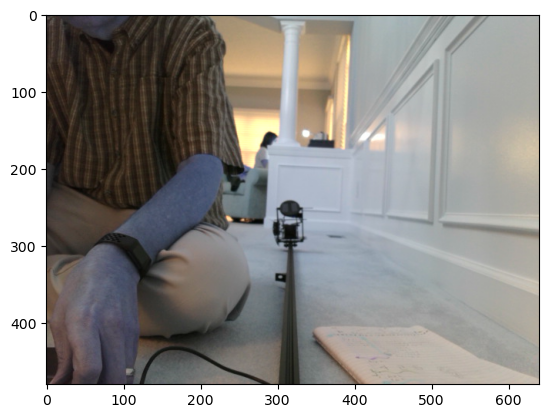

In [15]:
plt.imshow(image)

In [72]:
os.getcwd()

'C:\\Users\\sarah\\TiPaLiData'

In [9]:
tipali.getString("State", None)

In [11]:
nt

NameError: name 'nt' is not defined

In [15]:
help(NetworkTables)

Help on NetworkTablesInstance in module _pynetworktables.instance object:

class NetworkTablesInstance(builtins.object)
 |  The object ``networktables.NetworkTables`` is a global singleton that
 |  you can use to initialize NetworkTables connections, configure global
 |  settings and listeners, and to create table objects which can be used
 |  to send data to/from NetworkTable servers and clients.
 |
 |  First, you must initialize NetworkTables::
 |
 |      from networktables import NetworkTables
 |
 |      # As a client to connect to a robot
 |      NetworkTables.initialize(server='roborio-XXX-frc.local')
 |
 |  Then, to interact with the SmartDashboard you get an instance of the
 |  table, and you can call the various methods::
 |
 |      sd = NetworkTables.getTable('SmartDashboard')
 |
 |      sd.putNumber('someNumber', 1234)
 |      otherNumber = sd.getNumber('otherNumber')
 |
 |  You can create additional NetworkTablesInstance objects.
 |  Instances are completely independent from

In [19]:
NetworkTables.isConnected()

True

In [21]:
NetworkTables.isServer()

False

In [65]:
dc.cap.get(cv2.CAP_PROP_AUTO_EXPOSURE)

0.0

In [67]:
dc.cap.get(cv2.CAP_PROP_EXPOSURE)

0.0